# Tutorial: scaffolding a linear motif to create SH3 binders

This demonstrates scaffolding a linear peptide from 2w0z with the goal of binding an SH3 domain. 

Here we will do monomer hallucination followed by 2-chain refinement, and score final outputs using AlphaFold2 interface predictions. For hallucination here, we will use the `rf_Nov05_2021` version of RoseTTAFold, which is currently the best model (as of Jan 2022).

If you haven't already, look through the PD-L1 binder hallucination tutorial to get the basics. This has less explanation but more steps, which is a more realistic design scenario.

Working commands below call scripts using relative paths from this folder (`<rfdesign repo>/tutorials/halluc_SH3_binder/`). Some paths instead have a placeholder `<rfdesign repo>`, which should be replaced with the path to your clone of the RFDesign repository.

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import glob, os, shutil

In [3]:
import sys
sys.path.append("util/") # some functions to make plotting/analysis easier
from plotting import *
from functions import *

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
figdir = 'fig/'

## Run 1: Monomer hallucination

This will use gradient descent to generate scaffolds holding the linear motif, with a repulsive loss to avoid clashes with the binding target.

The goal is to generate good-looking scaffolds. We will fine-tune its sequence and interactions with the binding target in a second step (see run 2).

### Generate commands

In [6]:
ref_pdb = 'input/SH3_2w0z.pdb'
receptor = 'input/SH3_2w0z_rec.pdb'
run = 'sh3_r1'
contigs = 'B7-14'
force_aa = 'B7-14'

batch = 2
start_num = 0
total_num = 200
outdir = f'output/20220103_{run}/'

with open('r1.list','w') as outf:
    for istart in np.arange(start_num, start_num+total_num, batch):
        os.makedirs(outdir,exist_ok=True)
        if all([os.path.exists(f'{outdir}{run}_{j}.pdb') for j in range(istart, istart+batch)]):
            continue

        run_name = f'{run}'
        logfile = f'{outdir}/{run_name}_{istart}.log'
        trd_cmd = f'source activate SE3-nvidia; python ../../hallucination/hallucinate.py '\
                  f'--network_name rf_Nov05_2021 '\
                  f'--pdb={ref_pdb} --out={outdir}/{run_name} --contigs={contigs} --len=55-100 '\
                  f'--steps=g600 --num={batch} --start_num={istart} '\
                  f'--w_rep=2 --rep_sigma=3.5 --rep_pdb={receptor} '\
                  f'--w_rog=1 --rog_thresh=16 '\
                  f'--force_aa {force_aa} --exclude_aa C --save_pdb=True --track_step=10 --cautious=True '\
                  f'&>> {logfile}'

        print(trd_cmd, file=outf)

Run using:

    ./array_submit.sh r1.list

### Scoring

Generate relaxed design models with side chains:

    cd output/20220103_sh3_r1/
    <rfdesign repo>/scripts/trfold_relax.sh .
    
wait until finished, then:

    cd trf_relax
    sbatch -p gpu -c 2 --mem 12g --gres gpu:rtx2080:1 --wrap "<rfdesign repo>/scripts/af2_metrics.py ."
    sbatch --mem 5g --wrap "<rfdesign repo>/scripts/pyrosetta_metrics.py ."
    <rfdesign repo>/scripts/compile_metrics.py .
    

### Analyze

In [7]:
datadir = 'output/20220103_sh3_r1/'

In [8]:
df = pd.read_csv(datadir+'trf_relax/combined_metrics.csv')
df['folder'] = datadir+'trf_relax/'

In [9]:
df.shape

(200, 24)

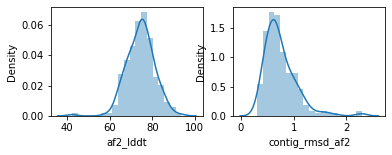

In [10]:
fig,axes = plt.subplots(1,2,figsize=(6,2))
for ax, metric in zip(axes.flat,['af2_lddt','contig_rmsd_af2']):
    sns.distplot(df[metric],ax=ax)

### Pick hits

In [17]:
import shutil

In [30]:
hits = df[(df['af2_lddt']>80) & (df['contig_rmsd_af2']<0.6) & (df['contig_rmsd']<1) & (df['rog']<16)
          & (df['topology']!='HH')]

In [31]:
hits.shape

(13, 24)

In [32]:
hits[['name','af2_lddt','contig_rmsd_af2','rog','topology']]

,name,af2_lddt,contig_rmsd_af2,rog,topology
14,sh3_r1_120,82.917949,0.558620,13.438005,HHHH
17,sh3_r1_112,81.830960,0.472451,11.803300,HHH
40,sh3_r1_87,81.388544,0.539688,13.514336,HHHH
45,sh3_r1_192,86.161309,0.536761,11.573707,HHH
56,sh3_r1_33,80.818507,0.569302,12.369105,HHHH
86,sh3_r1_22,81.911010,0.419346,13.836364,HHHH
99,sh3_r1_85,85.730110,0.410799,12.039831,HHH
102,sh3_r1_146,85.665627,0.465928,12.251873,HHH
123,sh3_r1_66,88.249932,0.532329,11.887709,HHHH
133,sh3_r1_110,86.046411,0.305571,13.929003,HHHH


In [33]:
outdir = 'output/hits_sh3_r1/'
os.makedirs(outdir, exist_ok=True)
os.makedirs(outdir+'af2/', exist_ok=True)

In [34]:
for i,row in hits.iterrows():
    shutil.copyfile(row['folder']+'/'+row['name']+'.pdb', outdir+row['name']+'.pdb')  
    shutil.copyfile(row['folder']+'af2/'+row['name']+'.pdb', outdir+'af2/'+row['name']+'_af2pred.pdb')    # copy af2 model
    shutil.copyfile(row['folder']+'../'+row['name']+'.trb', outdir+row['name']+'.trb')    
    shutil.copyfile(row['folder']+'../'+row['name']+'.fas', outdir+row['name']+'.fas')    

In [35]:
hits.to_csv(outdir+'metrics.csv')

Align hits and save to pymol session for visual inspection

    cd output/hits_sh3_r1/
    <rfdesign repo>/scripts/pymol_align.py --template ../../input/SH3_2w0z.pdb -o aligned.pse *pdb 
    
Most of these look good by eye. Some don't look amazing, or have weird sequences (lots of surface M), but I will just do 2-chain refinement on all of these hits (which might rescue some minor defects) and do more stringent filtering after that.

## Run 2: 2-chain MCMC refinement from run 1 hits
2021-1-4

This run will take hits from run 1 and continue to mutate them, but in the context of the receptor (both are being predicted by RoseTTAFold). This will allow us to build interface interactions, and also include (non-differentiable) losses to avoid surface hydrophobics and decrease the surface charge (to a target of -7).

In [12]:
ref_pdb = 'input/SH3_2w0z.pdb'
receptor = 'input/SH3_2w0z_rec.pdb'
seeds = glob.glob('output/hits_sh3_r1/*pdb')
run = 'r2'
contigs = 'B7-14'
force_aa = 'B7-14'

batch = 5
start_num = 0
total_num = 50 # per seed design
outdir = f'output/20220104_sh3_{run}/'
os.makedirs(outdir,exist_ok=True)

with open(run+'.list','w') as outf:
    for istart in np.arange(start_num, start_num+total_num, batch):
        for fn in seeds:
            name = os.path.basename(fn.replace('.pdb',''))
            if all([os.path.exists(f'{outdir}{run}_{j}.pdb') for j in range(istart, istart+batch)]):
                continue

            trb = np.load(fn.replace('.pdb','.trb'),allow_pickle=True)

            run_name = f'{name}_{run}'
            logfile = f'{outdir}/{run_name}_{istart}.log'
            trd_cmd = f'source activate SE3-nvidia; python ../../hallucination/hallucinate.py '\
                      f'--network_name rf_Nov05_2021 '\
                      f'--pdb={ref_pdb} --out={outdir}/{run_name} '\
                      f'--mask {trb["sampled_mask"]} --use_template {contigs} '\
                      f'--spike_fas {fn.replace(".pdb",".fas")} --spike 0.999 '\
                      f'--force_aa {force_aa} --exclude_aa C '\
                      f'--receptor {receptor} --rec_placement second --w_surfnp 1 --w_nc 0.02 '\
                      f'--steps=m300 --num={batch} --start_num={istart} '\
                      f'--w_rog=1 --rog_thresh=16 '\
                      f'--save_pdb=True --track_step=1 --cautious=True '\
                      f'&>> {logfile}'

            print(trd_cmd, file=outf)

Run commands:

    ./array_submit r2.list

### Scoring
Generate relaxed models:

    cd output/20220104_sh3_r2/
    <rfdesign repo>/scripts/trfold_relax.sh .

Then split up the files so scoring jobs can run faster.

In [7]:
split_folder('output/20220104_sh3_r2/trf_relax/', batch_size=50, trb_dir='../..')

Now run scoring jobs, looping over the subfolders. For this section you will need to install [`silent_tools`](https://github.com/bcov77/silent_tools).

AF2 prediction-based metrics, i.e. `pae_interaction`:

    for i in */; do sbatch -p gpu --mem 12g --gres gpu:rtx2080:1 -J af2int --wrap "cd $i; silentfrompdbs *pdb > in.silent; <rfdesign repo>/scripts/af2_interface_metrics.py -silent in.silent"; done
    
Relax AF2 predicted interfaces, then calculate interface metrics (ddg, contact MS, etc):

    for i in 0* 1*; do sbatch --mem 5g -J rel.$i --wrap "mkdir $i/relax; cd $i/relax; ln -s ../out.silent in.silent; /home/nrbennet/rosetta_builds/tutorial_build/main/source/cmake/build_release/rosetta_scripts @/home/nrbennet/protocols/flags/relax/relax.flags -parser:protocol /home/nrbennet/protocols/xml/relax/min/minterface.xml; silentextract out.silent; <rfdesign repo>/scripts/get_interface_metrics.py ."; done
    
Calculate RMSD of binder after superimposing on receptor:

    for i in 0* 1*; do sbatch --mem 2g --wrap "<rfdesign repo>/scripts/get_binder_rmsd.py $i"; done

### Analyze

In [67]:
filenames = sorted(glob.glob(f'output/20220104_sh3_r2/trf_relax/*/'))

In [68]:
df = pd.DataFrame()
for folder in filenames:
    if 'logs' in folder: continue
    tmp = load_af2_int_metrics(folder)
    df = df.append(tmp)

In [69]:
df.shape

(650, 31)

In [70]:
df.columns

Index(['SCORE:', 'pae_binder', 'pae_interaction', 'pae_interaction1',
       'pae_interaction2', 'pae_target', 'plddt_binder', 'plddt_target',
       'plddt_total', 'time', 'name', 'folder', 'Unnamed: 0_x',
       'binder_blocked_sap', 'buns_heavy_ball_1.1D',
       'contact_molec_sq5_apap_target', 'contact_molecular_surface',
       'contact_molecular_surface_ap_target',
       'contact_molecular_surface_apap_target', 'ddg', 'interface_buried_sasa',
       'interface_sc', 'mismatch_probability', 'sap_score', 'sap_score_target',
       'target_blocked_sap', 'Unnamed: 0_y', 'binder_rmsd_af2_des',
       'complex_rmsd_af2_des', 'binder_rmsd', 'complex_rmsd'],
      dtype='object')

In [72]:
seqs  = load_seqs('output/20220104_sh3_r2/')
df = df.merge(seqs,on='name')
df['seed'] = df['name'].apply(lambda x: '_'.join(x.split('_')[:-2]))
df['net_charge'] = df['seq'].apply(lambda x: x.count('K')+x.count('R')-x.count('D')-x.count('E'))

In [73]:
df.shape

(650, 34)

In [74]:
df = df[df['ddg']<20]

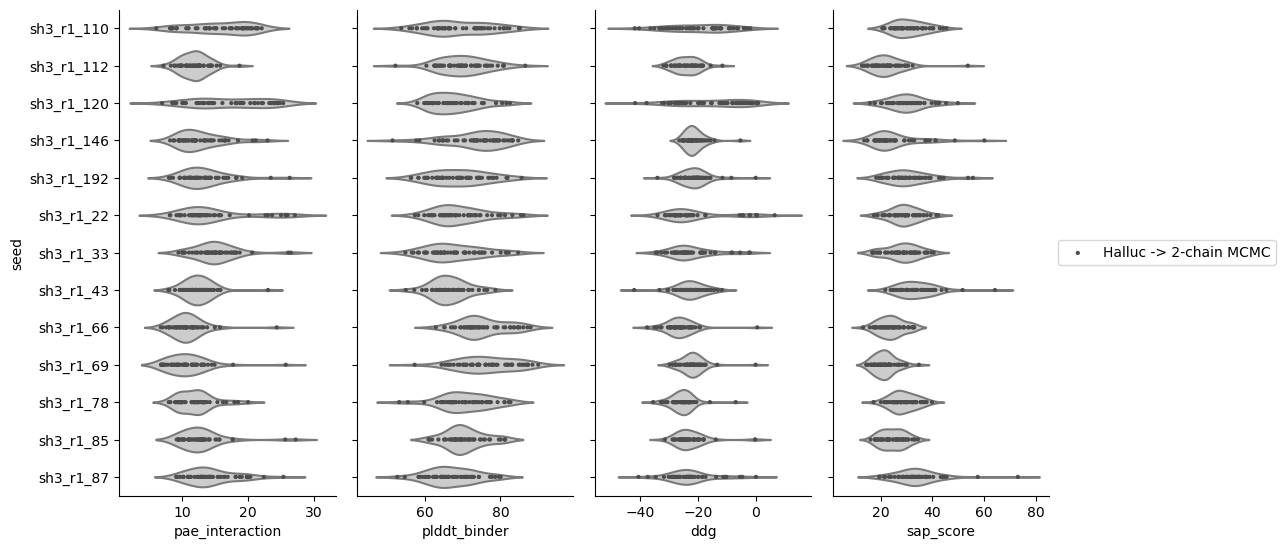

In [29]:
fig,axes = plt.subplots(1,4,figsize=(12,6))
plt.subplots_adjust(wspace=0.1,hspace=0.2,top=0.92)
for ax,metric in zip(axes.flat,['pae_interaction','plddt_binder','ddg','sap_score']):
    sns.violinplot(data=df,y='seed',x=metric,ax=ax,color=[.8]*3,zorder=-1,inner=None)
    sns.stripplot(data=df,y='seed',x=metric,ax=ax,color=[.3]*3,s=3,jitter=False,
                  label='Halluc -> 2-chain MCMC',zorder=1)
#     sns.stripplot(data=seed,y='seed',x=metric,ax=ax,color='r',s=5,jitter=False,
#                   label='Seed',zorder=1)
    yl = ax.get_ylim()
    ax.set_ylim(yl)
#     ax.plot([native[metric].values[0]]*2,yl,'-',color='C0',linewidth=1,label='Native')
    if ax!=axes.flat[0]:
        ax.set_yticklabels('')
        ax.set_ylabel('')
outside_legend(ax)
sns.despine()
# plt.suptitle('Improving EpcamBind1_cb4 using inpainting + MPNN');

These results look pretty good! We need `pae_interaction < 10` to expect binding activity, and `plddt_binder` should also be ideally >80.

### Hits

In [47]:
hits = df[(df['pae_interaction']<10) & (df['plddt_binder']>80) & (df['sap_score']<35) & (df['binder_rmsd_af2_des']<5) 
          & (df['net_charge']<=-5)]

In [48]:
hits.shape

(45, 34)

In [49]:
outdir = 'output/hits_sh3_r2/'
os.makedirs(outdir, exist_ok=True)
os.makedirs(outdir+'af2/', exist_ok=True)

In [50]:
for i,row in hits.iterrows():
    shutil.copyfile(row['folder']+'/'+row['name']+'.pdb', outdir+row['name']+'.pdb')  
#     shutil.copyfile(row['folder']+'af2/'+row['name']+'.pdb', outdir+'af2/'+row['name']+'_af2pred.pdb')    # copy af2 model
    shutil.copyfile(row['folder']+'../../'+row['name']+'.trb', outdir+row['name']+'.trb')    
    shutil.copyfile(row['folder']+'../../'+row['name']+'.fas', outdir+row['name']+'.fas')    

In [51]:
hits.to_csv(outdir+'metrics.csv')

### Align in Pymol
Our script `<rfdesign repo>/scripts/pymol_align.py` can only align monomer hallucinations to the reference pdb. To align the 2-chain hallucinations from this step to reference, let's use the code below to generate commands for aligning outputs to reference structures, and paste them manually into a pymol session.

In [13]:
for fn in glob.glob('output/hits_sh3_r2/*pdb'):
    print(f'load {fn}')

load output/hits_sh3_r2/sh3_r1_110_r2_32.pdb
load output/hits_sh3_r2/sh3_r1_146_r2_5.pdb
load output/hits_sh3_r2/sh3_r1_69_r2_11.pdb
load output/hits_sh3_r2/sh3_r1_146_r2_46.pdb
load output/hits_sh3_r2/sh3_r1_69_r2_5.pdb
load output/hits_sh3_r2/sh3_r1_78_r2_3.pdb
load output/hits_sh3_r2/sh3_r1_66_r2_2.pdb
load output/hits_sh3_r2/sh3_r1_66_r2_17.pdb
load output/hits_sh3_r2/sh3_r1_69_r2_35.pdb
load output/hits_sh3_r2/sh3_r1_69_r2_32.pdb
load output/hits_sh3_r2/sh3_r1_120_r2_2.pdb
load output/hits_sh3_r2/sh3_r1_146_r2_40.pdb
load output/hits_sh3_r2/sh3_r1_78_r2_13.pdb
load output/hits_sh3_r2/sh3_r1_120_r2_36.pdb
load output/hits_sh3_r2/sh3_r1_66_r2_47.pdb
load output/hits_sh3_r2/sh3_r1_192_r2_31.pdb
load output/hits_sh3_r2/sh3_r1_69_r2_22.pdb
load output/hits_sh3_r2/sh3_r1_66_r2_18.pdb
load output/hits_sh3_r2/sh3_r1_112_r2_19.pdb
load output/hits_sh3_r2/sh3_r1_146_r2_11.pdb
load output/hits_sh3_r2/sh3_r1_66_r2_16.pdb
load output/hits_sh3_r2/sh3_r1_66_r2_3.pdb
load output/hits_sh3_r2/sh3_r

In [6]:
sys.path.append('../../hallucination/util/')
from contigs import SampledMask # a utility for manipulating protein residue numbers

In [60]:
for fn in sorted(glob.glob('output/hits_sh3_r2/*trb')):
    name = os.path.basename(fn).replace('.trb','')
    trb = np.load(fn,allow_pickle=True)
    
    i_binder = [i for i,idx in enumerate(trb['con_ref_pdb_idx']) if idx[0]!='R']
    i_receptor = [i for i,idx in enumerate(trb['con_ref_pdb_idx']) if idx[0]=='R']

    idx_binder_ref = [idx for i,idx in enumerate(trb['con_ref_pdb_idx']) if i in i_binder]
    idx_binder_hal = [idx for i,idx in enumerate(trb['con_hal_pdb_idx']) if i in i_binder]

    ref_str = SampledMask.contract(idx_binder_ref)
    hal_str = SampledMask.contract(idx_binder_hal)
    binder_str = f'/{name}//{hal_str[0]}/{hal_str[1:]}/N, /SH3_2w0z//{ref_str[0]}/{ref_str[1:]}/N'
    print(f'sele {name}_motif, /{name}//{hal_str[0]}/{hal_str[1:]}') # create selection for the hallucinated linear motif

    idx_receptor_ref = [('A',idx[1]) for i,idx in enumerate(trb['con_ref_pdb_idx']) if i in i_receptor]
    idx_receptor_hal = [('B',idx[1]) for idx in trb['receptor_pdb_idx']]

    ref_str = SampledMask.contract(idx_receptor_ref)
    hal_str = SampledMask.contract(idx_receptor_hal)
    receptor_str = f'/{name}//{hal_str[0]}/{hal_str[1:]}/N, /SH3_2w0z//{ref_str[0]}/{ref_str[1:]}/N'

    print(f'pair_fit {binder_str}, {receptor_str}') # superimpose hallucination on reference structure

pair_fit /sh3_r1_110_r2_15//A/29-36/N, /SH3_2w0z//B/7-14/N, /sh3_r1_110_r2_15//B/96-153/N, /SH3_2w0z//A/1-58/N
sele sh3_r1_110_r2_15_motif, /sh3_r1_110_r2_15//B/96-153
pair_fit /sh3_r1_110_r2_32//A/29-36/N, /SH3_2w0z//B/7-14/N, /sh3_r1_110_r2_32//B/96-153/N, /SH3_2w0z//A/1-58/N
sele sh3_r1_110_r2_32_motif, /sh3_r1_110_r2_32//B/96-153
pair_fit /sh3_r1_110_r2_45//A/29-36/N, /SH3_2w0z//B/7-14/N, /sh3_r1_110_r2_45//B/96-153/N, /SH3_2w0z//A/1-58/N
sele sh3_r1_110_r2_45_motif, /sh3_r1_110_r2_45//B/96-153
pair_fit /sh3_r1_112_r2_19//A/45-52/N, /SH3_2w0z//B/7-14/N, /sh3_r1_112_r2_19//B/71-128/N, /SH3_2w0z//A/1-58/N
sele sh3_r1_112_r2_19_motif, /sh3_r1_112_r2_19//B/71-128
pair_fit /sh3_r1_112_r2_21//A/45-52/N, /SH3_2w0z//B/7-14/N, /sh3_r1_112_r2_21//B/71-128/N, /SH3_2w0z//A/1-58/N
sele sh3_r1_112_r2_21_motif, /sh3_r1_112_r2_21//B/71-128
pair_fit /sh3_r1_112_r2_5//A/45-52/N, /SH3_2w0z//B/7-14/N, /sh3_r1_112_r2_5//B/71-128/N, /SH3_2w0z//A/1-58/N
sele sh3_r1_112_r2_5_motif, /sh3_r1_112_r2_5//B/71-